In [203]:
import keras
import h5py
import numpy as np
from tqdm import tqdm
from keras.models import Model
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.layers import Input, GlobalAveragePooling2D, Dense

In [204]:
cl_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/cl/valid.h5'
bd_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/bd/bd_valid.h5'
model_path = r'/Users/yogyasharma/Downloads/Lab3/models/bd_net.h5'

def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

clean_x_test, clean_y_test = load_data(cl_data_path)
bd_x_test, bd_y_test = load_data(bd_data_path)

badnet_model = keras.models.load_model(model_path)

clean_label_pred = np.argmax(badnet_model.predict(clean_x_test), axis=1)
clean_clf_acc = np.mean(np.equal(clean_label_pred, clean_y_test)) * 100
print('Classification Accuracy on Clean Data:', clean_clf_acc)

bd_label_pred = np.argmax(badnet_model.predict(bd_x_test), axis=1)
attack_success_rate = np.mean(np.equal(bd_label_pred, bd_y_test)) * 100
print('Attack Success Rate:', attack_success_rate)


361/361 [==============================] - 1s 4ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 1s 4ms/step
Attack Success Rate: 100.0


In [205]:
print(badnet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [206]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(badnet_model)
model_copy.set_weights(badnet_model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_models = [False, False, False]

# Getting the activation from the last pooling layer
layer_output = model_copy.get_layer('pool_3').output
interm_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
interm_prediction = interm_model.predict(cl_x_test)
temp = np.mean(interm_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])
    cl_label_pred = np.argmax(model_copy.predict(cl_x_test), axis=1)
    cl_accuracy = np.mean(np.equal(cl_label_pred, cl_y_test)) * 100
    
    for i, threshold in enumerate([2, 4, 10]):
        if (clean_data_acc - cl_accuracy >= threshold) and not saved_models[i]:
            print(f"The accuracy drops by at least {threshold}%, model is saved.")
            model_copy.save(f'model_threshold_{threshold}.h5')
            saved_models[i] = True

    clean_acc.append(cl_accuracy)
    bd_label_pred = np.argmax(model_copy.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_pred, bd_y_test)) * 100
    asrate.append(asr)

    # Display pruning information
    print("Clean Classification Accuracy: ", cl_accuracy)
    print("Attack Success Rate: ", asr)
    print("Pruned Channel Index: ", channel_index)

    # Clear the session at the end
    keras.backend.clear_session()


401/401 [==============================] - 1s 3ms/step


  0%|                                                    | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  0


  2%|▋                                           | 1/60 [00:03<03:27,  3.52s/it]

361/361 [==============================] - 1s 4ms/step


  3%|█▍                                          | 2/60 [00:06<03:16,  3.39s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  26
361/361 [==============================] - 1s 4ms/step


  5%|██▏                                         | 3/60 [00:10<03:13,  3.39s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  30
361/361 [==============================] - 1s 4ms/step


  7%|██▉                                         | 4/60 [00:13<03:07,  3.35s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  31
361/361 [==============================] - 1s 4ms/step


  8%|███▋                                        | 5/60 [00:16<03:02,  3.31s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  33
361/361 [==============================] - 1s 4ms/step


 10%|████▍                                       | 6/60 [00:20<03:11,  3.55s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  34
361/361 [==============================] - 1s 4ms/step


 12%|█████▏                                      | 7/60 [00:24<03:04,  3.49s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  36
361/361 [==============================] - 1s 4ms/step


 13%|█████▊                                      | 8/60 [00:27<03:07,  3.61s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  37
361/361 [==============================] - 1s 4ms/step


 15%|██████▌                                     | 9/60 [00:31<03:09,  3.71s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  38
361/361 [==============================] - 1s 4ms/step


 17%|███████▏                                   | 10/60 [00:35<02:59,  3.59s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  39
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  40


 18%|███████▉                                   | 11/60 [00:39<03:01,  3.70s/it]

361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  41


 20%|████████▌                                  | 12/60 [00:42<02:57,  3.69s/it]

361/361 [==============================] - 1s 4ms/step


 22%|█████████▎                                 | 13/60 [00:46<02:48,  3.58s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  44
361/361 [==============================] - 1s 4ms/step


 23%|██████████                                 | 14/60 [00:49<02:46,  3.61s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  45
361/361 [==============================] - 1s 4ms/step


 25%|██████████▊                                | 15/60 [00:54<02:50,  3.79s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  47
361/361 [==============================] - 1s 4ms/step


 27%|███████████▍                               | 16/60 [00:57<02:39,  3.64s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  48
361/361 [==============================] - 1s 4ms/step


 28%|████████████▏                              | 17/60 [01:00<02:32,  3.55s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  49
361/361 [==============================] - 1s 4ms/step


 30%|████████████▉                              | 18/60 [01:04<02:28,  3.53s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  50
361/361 [==============================] - 2s 6ms/step


 32%|█████████████▌                             | 19/60 [01:08<02:36,  3.83s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  53
361/361 [==============================] - 1s 4ms/step


 33%|██████████████▎                            | 20/60 [01:12<02:39,  3.98s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  55
361/361 [==============================] - 1s 4ms/step


 35%|███████████████                            | 21/60 [01:16<02:33,  3.94s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  25
361/361 [==============================] - 1s 4ms/step


 37%|███████████████▊                           | 22/60 [01:20<02:24,  3.81s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  24
361/361 [==============================] - 1s 4ms/step


 38%|████████████████▍                          | 23/60 [01:24<02:22,  3.85s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  59
361/361 [==============================] - 1s 4ms/step


 40%|█████████████████▏                         | 24/60 [01:28<02:19,  3.86s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  9
361/361 [==============================] - 1s 4ms/step


 42%|█████████████████▉                         | 25/60 [01:31<02:11,  3.76s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  2
361/361 [==============================] - 1s 4ms/step


 43%|██████████████████▋                        | 26/60 [01:35<02:08,  3.78s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  12
361/361 [==============================] - 1s 4ms/step


 45%|███████████████████▎                       | 27/60 [01:39<02:04,  3.78s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  13
361/361 [==============================] - 1s 4ms/step


 47%|████████████████████                       | 28/60 [01:42<01:56,  3.65s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  14
361/361 [==============================] - 1s 4ms/step


 48%|████████████████████▊                      | 29/60 [01:46<01:50,  3.58s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  15
361/361 [==============================] - 1s 4ms/step


 50%|█████████████████████▌                     | 30/60 [01:49<01:49,  3.67s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  17
361/361 [==============================] - 1s 4ms/step


 52%|██████████████████████▏                    | 31/60 [01:53<01:44,  3.60s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  27
361/361 [==============================] - 1s 4ms/step


 53%|██████████████████████▉                    | 32/60 [01:57<01:41,  3.63s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  23
361/361 [==============================] - 1s 4ms/step


 55%|███████████████████████▋                   | 33/60 [02:00<01:39,  3.68s/it]

Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  6
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.62042088854248
Attack Success Rate:  100.0
Pruned Channel Index:  32


 57%|████████████████████████▎                  | 34/60 [02:04<01:33,  3.60s/it]

361/361 [==============================] - 1s 4ms/step


 58%|█████████████████████████                  | 35/60 [02:07<01:30,  3.62s/it]

Clean Classification Accuracy:  98.61262665627436
Attack Success Rate:  100.0
Pruned Channel Index:  51
361/361 [==============================] - 1s 4ms/step


 60%|█████████████████████████▊                 | 36/60 [02:11<01:29,  3.72s/it]

Clean Classification Accuracy:  98.60483242400623
Attack Success Rate:  100.0
Pruned Channel Index:  22
361/361 [==============================] - 1s 4ms/step


 62%|██████████████████████████▌                | 37/60 [02:15<01:23,  3.61s/it]

Clean Classification Accuracy:  98.60483242400623
Attack Success Rate:  100.0
Pruned Channel Index:  21
361/361 [==============================] - 2s 4ms/step


 63%|███████████████████████████▏               | 38/60 [02:19<01:21,  3.71s/it]

Clean Classification Accuracy:  98.58924395947
Attack Success Rate:  100.0
Pruned Channel Index:  20
361/361 [==============================] - 1s 4ms/step


 65%|███████████████████████████▉               | 39/60 [02:23<01:19,  3.77s/it]

Clean Classification Accuracy:  98.55027279812938
Attack Success Rate:  100.0
Pruned Channel Index:  19
361/361 [==============================] - 1s 4ms/step


 67%|████████████████████████████▋              | 40/60 [02:26<01:13,  3.67s/it]

Clean Classification Accuracy:  98.53468433359313
Attack Success Rate:  100.0
Pruned Channel Index:  43
361/361 [==============================] - 1s 4ms/step


 68%|█████████████████████████████▍             | 41/60 [02:30<01:09,  3.63s/it]

Clean Classification Accuracy:  98.52689010132501
Attack Success Rate:  100.0
Pruned Channel Index:  58
361/361 [==============================] - 1s 4ms/step


 70%|██████████████████████████████             | 42/60 [02:33<01:05,  3.66s/it]

Clean Classification Accuracy:  98.269680436477
Attack Success Rate:  100.0
Pruned Channel Index:  3
361/361 [==============================] - 1s 4ms/step


 72%|██████████████████████████████▊            | 43/60 [02:37<01:01,  3.59s/it]

Clean Classification Accuracy:  97.88776305533905
Attack Success Rate:  100.0
Pruned Channel Index:  42
361/361 [==============================] - 1s 4ms/step


 73%|███████████████████████████████▌           | 44/60 [02:41<00:58,  3.65s/it]

Clean Classification Accuracy:  97.66173031956352
Attack Success Rate:  100.0
Pruned Channel Index:  1
401/401 [==============================] - 2s 4ms/step
The accuracy drops by at least 2%, model is saved.


/Users/yogyasharma/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 4ms/step


 75%|████████████████████████████████▎          | 45/60 [02:44<00:54,  3.66s/it]

Clean Classification Accuracy:  95.90023382696803
Attack Success Rate:  100.0
Pruned Channel Index:  29
361/361 [==============================] - 1s 4ms/step


 77%|████████████████████████████████▉          | 46/60 [02:48<00:49,  3.56s/it]

Clean Classification Accuracy:  95.5261106780982
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
361/361 [==============================] - 1s 4ms/step


 78%|█████████████████████████████████▋         | 47/60 [02:51<00:45,  3.50s/it]

Clean Classification Accuracy:  95.0584567420109
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56
401/401 [==============================] - 2s 4ms/step
The accuracy drops by at least 4%, model is saved.


361/361 [==============================] - 1s 4ms/step


 80%|██████████████████████████████████▍        | 48/60 [02:55<00:43,  3.64s/it]

Clean Classification Accuracy:  92.29150428682775
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
361/361 [==============================] - 1s 4ms/step


 82%|███████████████████████████████████        | 49/60 [02:58<00:38,  3.53s/it]

Clean Classification Accuracy:  91.8082618862042
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5
361/361 [==============================] - 1s 4ms/step


 83%|███████████████████████████████████▊       | 50/60 [03:02<00:34,  3.48s/it]

Clean Classification Accuracy:  91.30943102104443
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8
361/361 [==============================] - 1s 4ms/step


 85%|████████████████████████████████████▌      | 51/60 [03:05<00:32,  3.61s/it]

Clean Classification Accuracy:  89.84411535463757
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11
401/401 [==============================] - 1s 4ms/step
The accuracy drops by at least 10%, model is saved.


361/361 [==============================] - 1s 4ms/step


 87%|█████████████████████████████████████▎     | 52/60 [03:09<00:28,  3.55s/it]

Clean Classification Accuracy:  84.54403741231489
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
361/361 [==============================] - 1s 4ms/step


 88%|█████████████████████████████████████▉     | 53/60 [03:12<00:24,  3.56s/it]

Clean Classification Accuracy:  76.30553390491036
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
361/361 [==============================] - 1s 4ms/step


 90%|██████████████████████████████████████▋    | 54/60 [03:16<00:21,  3.62s/it]

Clean Classification Accuracy:  54.762275915822286
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
361/361 [==============================] - 1s 4ms/step


 92%|███████████████████████████████████████▍   | 55/60 [03:20<00:17,  3.52s/it]

Clean Classification Accuracy:  27.10054559625877
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
361/361 [==============================] - 1s 4ms/step


 93%|████████████████████████████████████████▏  | 56/60 [03:23<00:14,  3.53s/it]

Clean Classification Accuracy:  13.756819953234606
Attack Success Rate:  0.0
Pruned Channel Index:  18
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy: 

 95%|████████████████████████████████████████▊  | 57/60 [03:27<00:10,  3.61s/it]

 6.570537802026501
Attack Success Rate:  0.0
Pruned Channel Index:  4
361/361 [==============================] - 1s 4ms/step


 97%|█████████████████████████████████████████▌ | 58/60 [03:30<00:07,  3.55s/it]

Clean Classification Accuracy:  1.5198752922837102
Attack Success Rate:  0.0
Pruned Channel Index:  7
361/361 [==============================] - 1s 4ms/step


 98%|██████████████████████████████████████████▎| 59/60 [03:34<00:03,  3.52s/it]

Clean Classification Accuracy:  0.646921278254092
Attack Success Rate:  0.0
Pruned Channel Index:  52
361/361 [==============================] - 1s 4ms/step


100%|███████████████████████████████████████████| 60/60 [03:38<00:00,  3.63s/it]

Clean Classification Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57


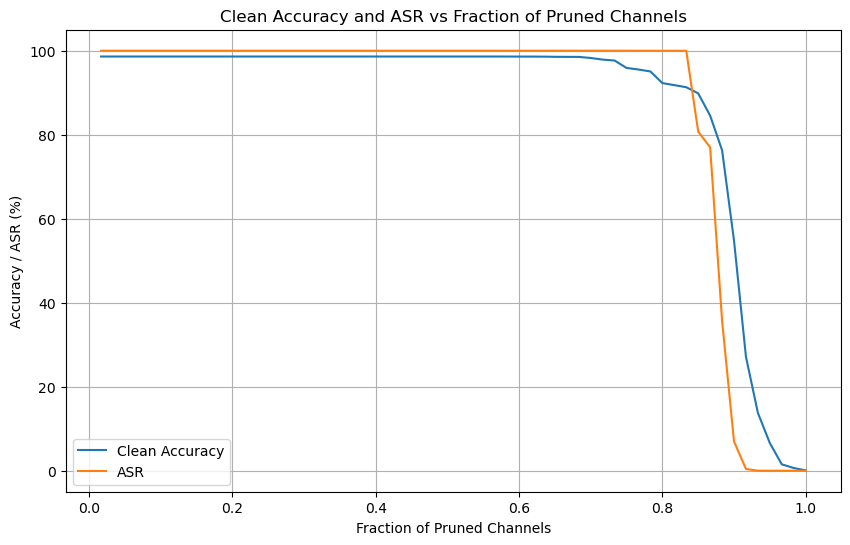

In [207]:
# Plot Clean Accuracy and ASR vs Fraction of Pruned Channels
pruned_fraction = np.arange(1,61)/60
plt.figure(figsize=(10, 6))
plt.plot(pruned_fraction, clean_acc, label='Clean Accuracy')
plt.plot(pruned_fraction, asrate, label='ASR')
plt.xlabel('Fraction of Pruned Channels')
plt.ylabel('Accuracy / ASR (%)')
plt.title('Clean Accuracy and ASR vs Fraction of Pruned Channels')
plt.legend()
plt.grid(True)
plt.show()


In [208]:
cl_test_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/cl/test.h5'         
bd_test_data_path = r'/Users/yogyasharma/Downloads/Lab3/data/bd/bd_test.h5' 

pruned_model_2_path = r'/Users/yogyasharma/model_threshold_2.h5'
pruned_model_4_path = r'/Users/yogyasharma/model_threshold_4.h5'
pruned_model_10_path = r'/Users/yogyasharma/model_threshold_10.h5'

# Loading the pruned models
pruned_model_2 = load_model(pruned_model_2_path)
pruned_model_4 = load_model(pruned_model_4_path)
pruned_model_10 = load_model(pruned_model_10_path)

# Loading the test images
def load_test_data(filepath):
    data = h5py.File(filepath, 'r')
    x_test = np.array(data['data'])
    y_test = np.array(data['label'])
    x_test = x_test.transpose((0, 2, 3, 1))
    return x_test, y_test

cl_x_test, cl_y_test = load_test_data(cl_test_data_path)
bd_x_test, bd_y_test = load_test_data(bd_test_data_path)

In [209]:
# Make predictions on clean data
pruned_clean_2 = np.argmax(pruned_model_2.predict(cl_x_test), axis = 1)
pruned_clean_4 = np.argmax(pruned_model_4.predict(cl_x_test), axis = 1)
pruned_clean_10 = np.argmax(pruned_model_10.predict(cl_x_test), axis = 1)

# Make predictions on backdoored data
pruned_bd_2 = np.argmax(pruned_model_2.predict(bd_x_test), axis = 1)
pruned_bd_4 = np.argmax(pruned_model_4.predict(bd_x_test), axis = 1)
pruned_bd_10 = np.argmax(pruned_model_10.predict(bd_x_test), axis = 1)

# Evaluate clean data accuracy
acc_clean_2 = np.mean(np.equal(pruned_clean_2, cl_y_test))
acc_clean_4 = np.mean(np.equal(pruned_clean_4, cl_y_test))
acc_clean_10 = np.mean(np.equal(pruned_clean_10, cl_y_test))

# Evaluate ASR
acc_bd_2 = np.mean(np.equal(pruned_bd_2, bd_y_test))
acc_bd_4 = np.mean(np.equal(pruned_bd_4, bd_y_test))
acc_bd_10 = np.mean(np.equal(pruned_bd_10, bd_y_test))

print("Clean Data Accuracy for pruned models:")
print(f"Model with 2% threshold: {acc_clean_2 * 100}")
print(f"Model with 2% threshold: {acc_clean_4 * 100}")
print(f"Model with 2% threshold: {acc_clean_10 * 100}")

print("\nAttack Success Rate for pruned models:")
print(f"Model with 2% threshold: {acc_bd_2 * 100}")
print(f"Model with 2% threshold: {acc_bd_4 * 100}")
print(f"Model with 2% threshold: {acc_bd_10 * 100}")

401/401 [==============================] - 2s 4ms/step
Clean Data Accuracy for pruned models:
Model with 2% threshold: 95.90023382696803
Model with 2% threshold: 92.29150428682775
Model with 2% threshold: 84.54403741231489

Attack Success Rate for pruned models:
Model with 2% threshold: 100.0
Model with 2% threshold: 99.98441153546376
Model with 2% threshold: 77.20966484801247


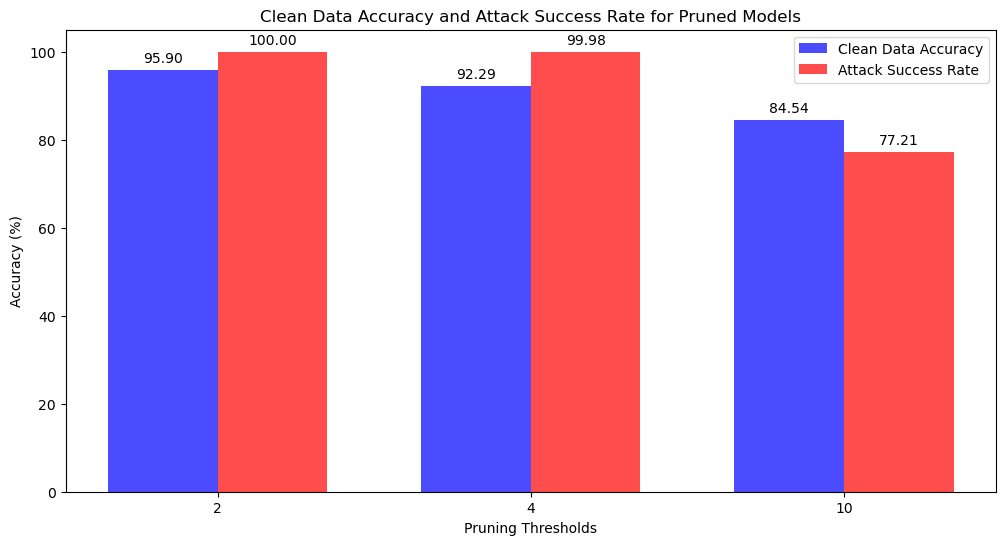

In [210]:
# Define the data
thresholds = [2, 4, 10]
acc_clean_data = [acc_clean_2 * 100, acc_clean_4 * 100, acc_clean_10 * 100]
acc_attack_success_rate = [acc_bd_2 * 100, acc_bd_4 * 100, acc_bd_10 * 100]

bar_width = 0.35
index = np.arange(len(thresholds))

# Plot grouped bar chart with markers
plt.figure(figsize=(12, 6))

plt.bar(index, acc_clean_data, bar_width, color='blue', alpha=0.7, label='Clean Data Accuracy')
plt.bar(index + bar_width, acc_attack_success_rate, bar_width, color='red', alpha=0.7, label='Attack Success Rate')

# Add markers
for i, value in enumerate(acc_clean_data):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

for i, value in enumerate(acc_attack_success_rate):
    plt.text(i + bar_width, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Pruning Thresholds')
plt.ylabel('Accuracy (%)')
plt.title('Clean Data Accuracy and Attack Success Rate for Pruned Models')
plt.xticks(index + bar_width / 2, thresholds)
plt.legend()

plt.show()


In [211]:
class GoodNet(keras.Model):
    def __init__(self, model_1, model_2):
        super(GoodNet, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2

    def predict(self, data):
        pred1 = np.argmax(self.model_1.predict(data), axis=1)
        pred2 = np.argmax(self.model_2.predict(data), axis=1)

        pred = np.where(pred1 == pred2, pred1, 1283)
        return pred

In [212]:
badnet_model = keras.models.load_model(model_path)

goodNet_2 = GoodNet(badnet_model, pruned_model_2)
goodNet_4 = GoodNet(badnet_model, pruned_model_4)
goodNet_10 = GoodNet(badnet_model, pruned_model_10)

In [213]:
# Make predictions on clean data
predictions_clean_2 = goodNet_2.predict(cl_x_test)
predictions_clean_4 = goodNet_4.predict(cl_x_test)
predictions_clean_10 = goodNet_10.predict(cl_x_test)

# Make predictions on backdoored data
predictions_bd_2 = goodNet_2.predict(bd_x_test)
predictions_bd_4 = goodNet_4.predict(bd_x_test)
predictions_bd_10 = goodNet_10.predict(bd_x_test)

# Evaluate clean data accuracy
acc_clean_2 = accuracy_score(cl_y_test, predictions_clean_2)
acc_clean_4 = accuracy_score(cl_y_test, predictions_clean_4)
acc_clean_10 = accuracy_score(cl_y_test, predictions_clean_10)

# Evaluate ASR
acc_bd_2 = accuracy_score(bd_y_test, predictions_bd_2)
acc_bd_4 = accuracy_score(bd_y_test, predictions_bd_4)
acc_bd_10 = accuracy_score(bd_y_test, predictions_bd_10)

print("Clean Data Accuracy for GoodNet:")
print(f"Model with 2% threshold: {acc_clean_2 * 100}")
print(f"Model with 4% threshold: {acc_clean_4 * 100}")
print(f"Model with 10% threshold: {acc_clean_10 * 100}")

print("\nAttack Success Rate for GoodNet:")
print(f"Model with 2% threshold: {acc_bd_2 * 100}")
print(f"Model with 4% threshold: {acc_bd_4 * 100}")
print(f"Model with 10% threshold: {acc_bd_10 * 100}")


401/401 [==============================] - 2s 4ms/step
Clean Data Accuracy for GoodNet:
Model with 2% threshold: 95.74434918160561
Model with 4% threshold: 92.1278254091972
Model with 10% threshold: 84.3335931410756

Attack Success Rate for GoodNet:
Model with 2% threshold: 100.0
Model with 4% threshold: 99.98441153546376
Model with 10% threshold: 77.20966484801247


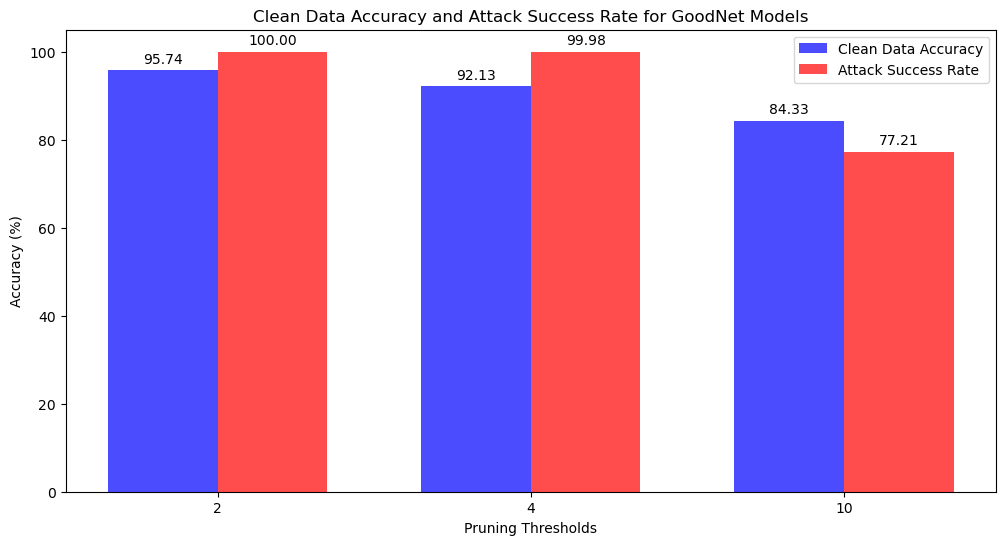

In [214]:
# Define the data
thresholds = [2, 4, 10]
acc_clean_data = [acc_clean_2 * 100, acc_clean_4 * 100, acc_clean_10 * 100]
acc_attack_success_rate = [acc_bd_2 * 100, acc_bd_4 * 100, acc_bd_10 * 100]

bar_width = 0.35
index = np.arange(len(thresholds))

# Plot grouped bar chart with markers
plt.figure(figsize=(12, 6))

plt.bar(index, acc_clean_data, bar_width, color='blue', alpha=0.7, label='Clean Data Accuracy')
plt.bar(index + bar_width, acc_attack_success_rate, bar_width, color='red', alpha=0.7, label='Attack Success Rate')

# Add markers
for i, value in enumerate(acc_clean_data):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

for i, value in enumerate(acc_attack_success_rate):
    plt.text(i + bar_width, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Pruning Thresholds')
plt.ylabel('Accuracy (%)')
plt.title('Clean Data Accuracy and Attack Success Rate for GoodNet Models')
plt.xticks(index + bar_width / 2, thresholds)
plt.legend()

plt.show()
